In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys

# Use this if running this notebook from within its place in the truera repository.
sys.path.insert(0, "../..")

# Install transformers / huggingface.
!{sys.executable} -m pip install torch
!{sys.executable} -m pip install transformers

# Or otherwise install trulens.
# !{sys.executable} -m pip install git+https://github.com/truera/trulens.git
# ! {sys.executable} -m pip uninstall trulens -y

from IPython.display import display
import torch
import matplotlib.pyplot as plt
import numpy as np

# Twitter Sentiment Model

[Huggingface](https://huggingface.co/models) offers a variety of pre-trained NLP models to explore. We exemplify in this notebook a [transformer-based twitter sentiment classification model](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment). Before getting started, familiarize yourself with the general Truera API as demonstrated in the [intro notebook using pytorch](intro_demo_pytorch.ipynb).

In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer

# Wrap all of the necessary components.
class TwitterSentiment:
    MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"

    #device = 'cpu'
    # Can also use cuda if available:
    device = 'cuda:0'

    model = AutoModelForSequenceClassification.from_pretrained(MODEL).to(device)
    tokenizer = AutoTokenizer.from_pretrained(MODEL)
    labels = ['negative', 'neutral', 'positive']

    NEGATIVE = labels.index('negative')
    NEUTRAL = labels.index('neutral')
    POSITIVE = labels.index('positive')

task = TwitterSentiment()

This model quantifies tweets (or really any text you give it) according to its sentiment: positive, negative, or neutral. Lets try it out on some examples.

In [ ]:
sentences = ["I'm so happy!", "I'm so sad!", "I cannot tell whether I should be happy or sad!", "meh"]

# Input sentences need to be tokenized first.

inputs = task.tokenizer(sentences, padding=True, return_tensors="pt").to(task.device) # pt refers to pytorch tensor

# The tokenizer gives us vocabulary indexes for each input token (in this case,
# words and some word parts like the "'m" part of "I'm" are tokens).

print(inputs)

# Decode helps inspecting the tokenization produced:

print(task.tokenizer.batch_decode(torch.flatten(inputs['input_ids'])))
# Normally decode would give us a single string for each sentence but we would
# not be able to see some of the non-word tokens there. Flattening first gives
# us a string for each input_id.

Evaluating huggingface models is straight-forward if we use the structure produced by the tokenizer.

In [ ]:
outputs = task.model(**inputs)

print(outputs)

# From logits we can extract the most likely class for each sentence and its readable label.

predictions = [task.labels[i] for i in outputs.logits.argmax(axis=1)]

for sentence, logits, prediction in zip(sentences, outputs.logits, predictions):
    print(logits.to('cpu').detach().numpy(), prediction, sentence)

# Model Wrapper

As in the prior notebooks, we need to wrap the pytorch model with the appropriate Trulens functionality. Here we specify the maximum input size (in terms of tokens) each tweet may have.

In [ ]:
from trulens.nn.models import get_model_wrapper
from trulens.nn.quantities import ClassQoI
from trulens.nn.attribution import IntegratedGradients
from trulens.nn.attribution import Cut, OutputCut
from trulens.utils.typing import ModelInputs

task.wrapper = get_model_wrapper(task.model, device=task.device)

# Attributions

In [ ]:
infl = IntegratedGradients(
    model = task.wrapper,
    doi_cut=Cut('roberta_embeddings_word_embeddings'),
    qoi=ClassQoI(task.POSITIVE),
    qoi_cut=OutputCut(accessor=lambda o: o['logits'])
)

A listing as above is not very readable so Trulens comes with some utilities to present token influences a bit more concisely. First we need to set up a few parameters to make use of it:

In [ ]:
from trulens.visualizations import NLP

V = NLP(
    wrapper=task.wrapper,
    labels=task.labels,
    decode=lambda x: task.tokenizer.decode(x),
    tokenize=lambda sentences: ModelInputs(kwargs=task.tokenizer(sentences, padding=True, return_tensors='pt')).map(lambda t: t.to(task.device)),
    # huggingface models can take as input the keyword args as per produced by their tokenizers.

    input_accessor=lambda x: x.kwargs['input_ids'],
    # for huggingface models, input/token ids are under input_ids key in the input dictionary

    output_accessor=lambda x: x['logits'],
    # and logits under 'logits' key in the output dictionary

    hidden_tokens=set([task.tokenizer.pad_token_id])
    # do not display these tokens
)

print("QOI = POSITIVE")
display(V.tokens(sentences, infl))

# Baselines

We see in the above results that special tokens such as the sentence end **&lt;/s&gt;** contributes are found to contribute a lot to the model outputs. While this may be useful in some contexts, we are more interested in the contributions of the actual words in these sentences. To focus on the words more, we need to adjust the **baseline** used in the integrated gradients computation. By default in the instantiation so far, the baseline for each token is a zero vector of the same shape as its embedding. By making the basaeline be identicaly to the explained instances on special tokens, we can rid their impact from our measurement. Trulens provides a utility for this purpose in terms of `token_baseline` which constructs for you the methods to compute the appropriate baseline. 

In [ ]:
from trulens.utils.nlp import token_baseline

inputs_baseline_ids, inputs_baseline_embeddings = token_baseline(
    keep_tokens=set([task.tokenizer.cls_token_id, task.tokenizer.sep_token_id]),
    # Which tokens to preserve.

    replacement_token=task.tokenizer.pad_token_id,
    # What to replace tokens with.

    input_accessor=lambda x: x.kwargs['input_ids'],

    ids_to_embeddings=task.model.get_input_embeddings()
    # Callable to produce embeddings from token ids.
)

We can now inspect the baselines on some example sentences. The first method returned by `token_baseline` gives us token ids to inspect while the second gives us the embeddings of the baseline which we will pass to the attributions method.

In [ ]:
print("originals=", task.tokenizer.batch_decode(inputs['input_ids']))

baseline_word_ids = inputs_baseline_ids(model_inputs=ModelInputs(args=[], kwargs=inputs))
print("baselines=", task.tokenizer.batch_decode(baseline_word_ids))

In [ ]:
infl_positive_baseline = IntegratedGradients(
    model = task.wrapper,
    resolution=50,
    baseline = inputs_baseline_embeddings,
    doi_cut=Cut('roberta_embeddings_word_embeddings'),
    qoi=ClassQoI(task.POSITIVE),
    qoi_cut=OutputCut(accessor=lambda o: o['logits'])
)

print("QOI = POSITIVE WITH BASELINE")
display(V.tokens(sentences, infl_positive_baseline))

In [217]:
from datasets import load_dataset
import multiprocessing as mp
p = mp.Pool(24)

imdb_train = load_dataset("imdb", "plain_text", split="train")
imdb_test = load_dataset("imdb", "plain_text", split="test")
rotten_train = load_dataset("rotten_tomatoes", split="train")
rotten_test = load_dataset("rotten_tomatoes", split="test")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [311]:
def tokenize(portion):
    return task.tokenizer.batch_encode_plus(portion, add_special_tokens=True, return_attention_mask=False)['input_ids']

def dists_of_texts(texts):
    toks = p.map(tokenize, [texts[1000*i: 1000*(i+1)] for i in range(len(texts)//1000)])
    all = np.array([i for tok in toks for t in tok for i in t ])

    counts = np.zeros(task.tokenizer.vocab_size)
    total = len(all)
    for i in all:
        counts[i] += 1

    dist = counts / total

    return counts, dist

def tops_of_texts(texts, n = 10):
    counts, dist = dists_of_texts(texts)

    return tops_of_dists(counts, dist, n=n)

def tops_of_dists(c, d, n=10):
    sortindex = np.argsort(d)
    top = []

    for idx in sortindex[0:n]:
        top.append((idx, c[idx], d[idx], task.tokenizer.decode(idx)))

    crest_pos = 0
    crest_neg = 0
    drest_pos = 0
    drest_neg = 0

    for idx in sortindex[n:-n]:
        if c[idx] >= 0:
            crest_pos += c[idx]
            drest_pos += d[idx]
        else:
            crest_neg += c[idx]
            drest_neg += d[idx]

    top.append((-1, crest_neg, drest_neg, "*"))
    top.append((-1, crest_pos, drest_pos, "*"))

    for idx in sortindex[-n:]:
        top.append((idx, c[idx], d[idx], task.tokenizer.decode(idx)))

    return top

In [312]:
c1, d1 = dists_of_texts(imdb_train['text'])
c2, d2 = dists_of_texts(rotten_train['text'])
top = tops_of_dists(c1 - c2, d1 - d2, n = 20)
sum([t[2] for t in top])

-5.197925423416905e-14

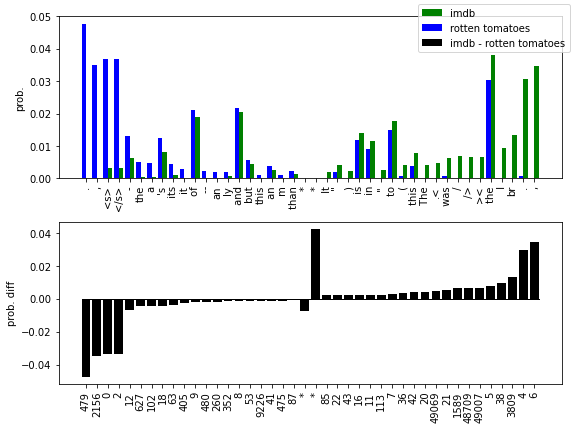

In [325]:
from matplotlib import transforms as trans

def plotdist(top, l1, l2):
    fig, ax = plt.subplots(2,1, figsize=(8,6))

    # ax[0].grid()
    ax[1].bar(x=range(len(top)), width=0.8, height=[t[2] for t in top], alpha=1.0, color="black", label=f"{l1} - {l2}")
    ax[0].bar(x=np.arange(len(top)) + 0.2, width=0.4, height=[d1[t[0]] if t[0]>=0 else 0 for t in top], alpha=1.0, color="green", label=l1)    
    ax[0].bar(x=np.arange(len(top)) - 0.2, width=0.4, height=[d2[t[0]] if t[0]>=0 else 0 for t in top], alpha=1.0, color="blue", label=l2)
    ax[0].set_xticks(ticks=range(len(top)), labels=[t[3] for t in top], rotation=90)
    ax[1].set_xticks(ticks=range(len(top)), labels=[str(t[0]) if t[0]>=0 else "*" for t in top], rotation=90)

    # ax[0].grid()
    # ax[1].grid()
    ax[1].plot([0,len(top)-0.6], [0,0], lw=1, color='black')

    ax[0].set_ylabel("prob.")
    ax[1].set_ylabel("prob. diff")

    fig.legend()
    fig.tight_layout()

plotdist(top, l1='imdb', l2='rotten tomatoes')

In [309]:
c1, d1 = dists_of_texts(imdb_train['text'])
c2, d2 = dists_of_texts(imdb_test['text'])
top = tops_of_dists(c1 - c2, d1 - d2, n = 20)
# top

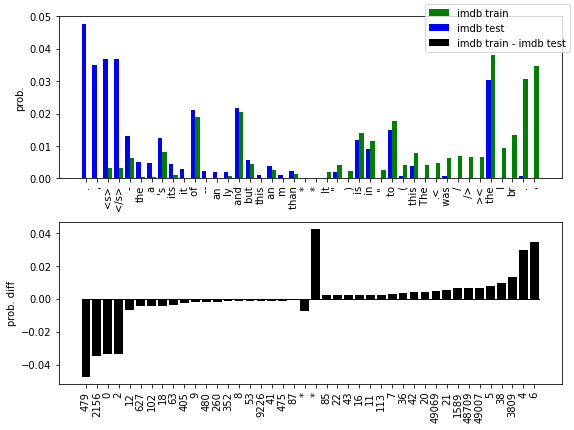

In [326]:

def plotdist(d1, d2, top, l1, l2):
    fig, ax = plt.subplots(2,1, figsize=(8,6))

    # ax[0].grid()
    ax[1].bar(x=range(len(top)), width=0.8, height=[t[2] for t in top], alpha=1.0, color="black", label=f"{l1} - {l2}")
    ax[0].bar(x=np.arange(len(top)) + 0.2, width=0.4, height=[d1[t[0]] if t[0]>=0 else 0 for t in top], alpha=1.0, color="green", label=l1)    
    ax[0].bar(x=np.arange(len(top)) - 0.2, width=0.4, height=[d2[t[0]] if t[0]>=0 else 0 for t in top], alpha=1.0, color="blue", label=l2)
    ax[0].set_xticks(ticks=range(len(top)), labels=[t[3] for t in top], rotation=90)
    ax[1].set_xticks(ticks=range(len(top)), labels=[str(t[0]) if t[0]>=0 else "*" for t in top], rotation=90)

    #ax[0].grid()
    #ax[1].grid()

    ax[1].plot([0,len(top) - 0.6], [0,0], lw=1, color='black')

    ax[0].set_ylabel("prob.")
    ax[1].set_ylabel("prob. diff")

    fig.legend()
    fig.tight_layout()

plotdist(d1=d1, d2=d2, top=top, l1='imdb train', l2='imdb test')